In [62]:
#Here is the first sample data set.
## MOCK DATA ########################################################3
##Data
num_nutrients = 3
num_foods = 5
num_ages = 2
num_stores = 3
num_categories = 2

nutrients = ["Vitamin A", "Calcium", "Protein"]
foods = ["Cake", "Pizza", "Milk", "Soup", "Apple"]
ages = ["Child", "Adult"]
stores = ["Woodmans", "Fresh Market", "Trader Joe's"]
categories = ["Dairy", "Fruit"]

min_req = [10 15  5    #(rows are age group, columns are requirement for each food)
           20 30 10]
max_req = [ 50 120  75
           100  90 150]
max_quant = [20, 100, 500, 300, 300] 
food_nutrients = [40   5   5     #(rows are foods, columns are nutrients)
                   5  10  40
                  20   0   0
                  10  30  10
                  10   5   0]    
#faraway but super cheap
food_prices = [200 101  205  4  2
               10 71 5  501  201
               2  9 207 3011 111 ]   #(rows are stores, columns are foods)

store_distance = [ 0 5 20 500
                   5 0 21 51 
                   20 21 0 32
                   500 51 32 0] #(rows are locations, columns are locations, distance from location i to location j)
C = 10
############################################################################################

10

In [63]:
using JuMP, Cbc, NamedArrays
println(1)

#-------------------------------------------------------------------------------------------------------------------------------#
println(2)
m = Model(solver=CbcSolver())

### Decision variable ###
@variable(m, food[1:num_foods] >= 0, Int)

### Constraints ###
#Min/Max nutrients
@constraint(m, min_nutrient[j in 1:num_nutrients], sum(food[i] * food_nutrients[i,j] for i in 1:num_foods) >= min_req[j] * 365)
@constraint(m, max_nutrient[j in 1:num_nutrients], sum(food[i] * food_nutrients[i,j] for i in 1:num_foods) <= max_req[j] * 365)
println(3)
#Max food amount (for variety in diet, and health reasons)
@constraint(m, max_food[i in 1:num_foods], food[i] <= 365 * max_quant[i])

### Objective: Minimize the total cost of all the foods bought ###
@objective(m, Min, sum(food[i] * food_prices[i] for i in 1:num_foods))
status = solve(m)

println("Shopping list (100mg per unit of food)")
print_with_color(:blue, "------------------------------\n")

for food_item in 1:num_foods
    if (getvalue(food[food_item]) > 0)
        println(foods[food_item], ": ", getvalue(food[food_item]))
    end
end

print_with_color(:blue, "------------------------------")
print("\nTotal Cost: ")
print_with_color(:green, "\$", getobjectivevalue(m))


1
2
3
Shopping list (100mg per unit of food)
------------------------------
Pizza: 730.0
------------------------------
Total Cost: $7300.0

In [64]:
using JuMP, Cbc, NamedArrays

#-------------------------------------------------------------------------------------------------------------------------------#
println(2)
m = Model(solver=CbcSolver())

### Decision variable ###
@variable(m, food[1:num_ages,1:num_stores,1:num_foods] >= 0, Int)
println(3)
### Constraints ###
println(3.5)
#Min/Max nutrients
@constraint(m, min_nutrient[a in 1:num_ages, j in 1:num_nutrients], sum(sum(food[a,s,i] for s in 1:num_stores)*food_nutrients[i,j] for i in 1:num_foods) >= min_req[a,j] * 365)
#@constraint(m, max_nutrient[a in 1:num_ages, j in 1:num_nutrients], sum(sum(food[a,s,i] for s in 1:num_stores)*food_nutrients[i,j] for i in 1:num_foods) <= max_req[a,j] * 365)
#Max food amount
#@constraint(m, max_food[i in 1:num_foods], food[i] <= max_quant[i])
#At least one food item per category
#@constraint(m, dairy[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 5:17) >= 1)
#@constraint(m, fruit[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 29:39) >= 1)
#@constraint(m, vegetable[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 41:46) >= 1)
#@constraint(m, grain[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 48:52) >= 1)
#@constraint(m, meat[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 59:72) >= 1)
#@constraint(m, MUST_DRINK_BEER[a in 2:num_ages], sum(food[a,s,1] for s in 1:num_stores) >= 1)

### Objective ###
println(4)
print(size(food_prices))
@objective(m, Min, sum(food[a,j,i] * food_prices[j,i] for i in 1:num_foods, j in 1:num_stores, a in 1:num_ages))
status = solve(m)
println(5)
println("Shopping list (100mg per unit of food)")
for age in 1:num_ages
    println("\n", ages[age], ":")
    for store in 1:num_stores
        println("\n", stores[store], ":")
        for food_item in 1:num_foods
            if (getvalue(food[age, store, food_item]) > 0)
                println(foods[food_item], ": ", getvalue(food[age, store, food_item]))
            end
        end
    end
    println("\nCost for ", ages[age], ": \$", sum(getvalue(food[age,j,i]) * food_prices[j,i] for i in 1:num_foods, j in 1:num_stores))
    println("_________________________")
end

println("\nTotal Cost: \$", getobjectivevalue(m))

2
3
3.5
4
(3, 5)5
Shopping list (100mg per unit of food)

Child:

Woodmans:
Soup: 175.0

Fresh Market:

Trader Joe's:
Cake: 48.0

Cost for Child: $796.0
_________________________

Adult:

Woodmans:
Soup: 349.0

Fresh Market:

Trader Joe's:
Cake: 96.0

Cost for Adult: $1588.0
_________________________

Total Cost: $2384.0


In [68]:
using JuMP, Cbc

###Data
#locations = #add locations
gas = 3
C = gas
function solveOpt(λ)
    m = Model(solver=CbcSolver())
    println(1)
    ##Decision variable
    @variable(m, food[1:num_ages,1:num_stores,1:num_foods] >= 0, Int)
    @variable(m, path[1:num_stores+1,1:num_stores+1], Bin)
    println(2)
    ##Constraints
    println(3)
    #Min/Max nutrients
    @constraint(m, min_nutrient[a in 1:num_ages, j in 1:num_nutrients], sum(sum(food[a,s,i] for s in 1:num_stores) * food_nutrients[i,j] for i in 1:num_foods) >= min_req[a,j] * 365)
    @constraint(m, max_nutrient[a in 1:num_ages, j in 1:num_nutrients], sum(sum(food[a,s,i] for s in 1:num_stores) * food_nutrients[i,j] for i in 1:num_foods) <= max_req[a,j] * 365)
    println(4)
    #Max food amount
    @constraint(m, max_food[a in 1:num_ages, i in 1:num_foods], sum(food[a,j,i] for j in 1:num_stores) <= max_quant[i])
    println(5)
    #At least one food item per category
    @constraint(m, MUST_EAT_CAKE[a in 1:num_ages], sum(food[a,s,1] for s in 1:num_stores) >= 1)
    @constraint(m, dairy[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 1:3) >= 1)
    @constraint(m, fruit[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 4:5) >= 1)
    @constraint(m, vegetable[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 4:5) >= 1)
    @constraint(m, grain[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 4:5) >= 1)
    @constraint(m, meat[a in 1:num_ages], sum(food[a,s,i] for s in 1:num_stores, i in 4:5) >= 1)
    println(6)
    # NOT One in and out edge --at most one in and out edge with equality
    @constraint(m, out[j in 1:num_stores+1], sum( path[i,j] for i in 1:num_stores+1) <= 1)      # one out-edge
    @constraint(m, inn[i in 1:num_stores+1], sum( path[i,j] for j in 1:num_stores+1) <= 1)      # one in-edge
    for k in 1:num_stores
        @constraint(m, sum( path[k,j] for j in 1:num_stores+1) == sum( path[i,k] for i in 1:num_stores+1))      # one in-edge
    end
    for b in 1:num_stores
        @constraint(m, sum(food[a,b,c] for a in 1:num_ages,c in 1:num_foods)<=10000000000000*sum( path[i,b] for i in 1:num_stores+1))
    end
    println(7)
    #No self loops
    @constraint(m, self[i in 1:num_stores+1], path[i,i] == 0 )
    println(1)

    ##Objective
    @objective(m, Min, sum(food[a,j,i] * food_prices[j,i] for i in 1:num_foods, j in 1:num_stores, a in 1:num_ages) + λ*sum(store_distance[k,l] * path[k,l] * gas for k in 1:num_stores, l in 1:num_stores))
    status = solve(m)
    #println(status)
    println(getvalue(path))
    #println(m)
    print_with_color(:yellow, "Optimal Path: ")
    println("Home --> Woodmans --> Fresh --> Home")
    println("Shopping list (100mg per unit of food)")
    #println(foods)
    for age in 1:num_ages
        print_with_color(:blue, "\n", ages[age], ":")
        for store in 1:num_stores
            print_with_color(:green, "\n", stores[store], ":")
            println()
            for food_item in 1:num_foods
                if (getvalue(food[age, store, food_item]) > 0)
                    println(foods[food_item], ": ", getvalue(food[age, store, food_item]))
                end
            end
        end
        println("\nCost for ", ages[age], ": \$", sum(getvalue(food[age,j,i]) * food_prices[j,i] for i in 1:num_foods, j in 1:num_stores))
        println("_________________________")
    end
    
    food_cost = sum(getvalue(food[a,j,i]) * food_prices[j,i] for i in 1:num_foods, j in 1:num_stores, a in 1:num_ages)
    println("\nTotal Food Cost: \$", food_cost)
    travel_cost = sum(store_distance[k,l] * getvalue(path[k,l]) * gas for k in 1:num_stores, l in 1:num_stores)
    println("Total Travel Cost: \$", travel_cost)
    println("Total Overall Cost: \$", food_cost + travel_cost)
    J1 = food_cost
    J2 = travel_cost
    println(getobjectivevalue(m))
    return(J1,J2)
end
println(solveOpt(10000))
println(solveOpt(0.00001))

1
2
3
4
5
6
7
1
[0.0 0.0 0.0 1.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0]
Optimal Path: Home --> Woodmans --> Fresh --> Home
Shopping list (100mg per unit of food)

Child:
Woodmans:
Cake: 1.0
Soup: 182.00000000000003
Apple: 179.0

Fresh Market:

Trader Joe's:

Cost for Child: $1286.0
_________________________

Adult:
Woodmans:
Cake: 20.0
Pizza: 36.0
Milk: 16.0
Soup: 300.0
Apple: 300.0

Fresh Market:

Trader Joe's:

Cost for Adult: $12716.0
_________________________

Total Food Cost: $14002.0
Total Travel Cost: $0.0
Total Overall Cost: $14002.0
14002.0
(14002.0, 0.0)
1
2
3
4
5
6
7
1
[0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0]
Optimal Path: Home --> Woodmans --> Fresh --> Home
Shopping list (100mg per unit of food)

Child:
Woodmans:
Soup: 157.0
Apple: 126.0

Fresh Market:

Trader Joe's:
Cake: 20.0
Pizza: 4.0

Cost for Child: $956.0
_________________________

Adult:
Woodmans:
Soup: 300.0
Apple: 300.0

Fresh Market:
Milk: 17.0

Trader Joe's:
Cake: 20.0
P

In [71]:
Npts = 10
J1 = zeros(Npts)
J2 = zeros(Npts)

λ = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

for i in 1:10
    (J1[i],J2[i]) = solveOpt(λ[i])
end;
println(J1)
println(J2)

1
2
3
4
5
6
7
1
[0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0]
Optimal Path: Home --> Woodmans --> Fresh --> Home
Shopping list (100mg per unit of food)

Child:
Woodmans:
Soup: 157.0
Apple: 126.0

Fresh Market:

Trader Joe's:
Cake: 20.0
Pizza: 4.0

Cost for Child: $956.0
_________________________

Adult:
Woodmans:
Soup: 300.0
Apple: 300.0

Fresh Market:
Milk: 17.0

Trader Joe's:
Cake: 20.0
Pizza: 35.0

Cost for Adult: $2240.0
_________________________

Total Food Cost: $3196.0
Total Travel Cost: $30.0
Total Overall Cost: $3226.0
3196.000299999995
1
2
3
4
5
6
7
1
[0.0 1.0 0.0 0.0; 1.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0; 0.0 0.0 1.0 0.0]
Optimal Path: Home --> Woodmans --> Fresh --> Home
Shopping list (100mg per unit of food)

Child:
Woodmans:
Soup: 157.0
Apple: 126.0

Fresh Market:

Trader Joe's:
Cake: 20.0
Pizza: 4.0

Cost for Child: $956.0
_________________________

Adult:
Woodmans:
Soup: 300.0
Apple: 300.0

Fresh Market:
Milk: 17.0

Trader Joe's:
Cake: 20.0
Pizza: 35.

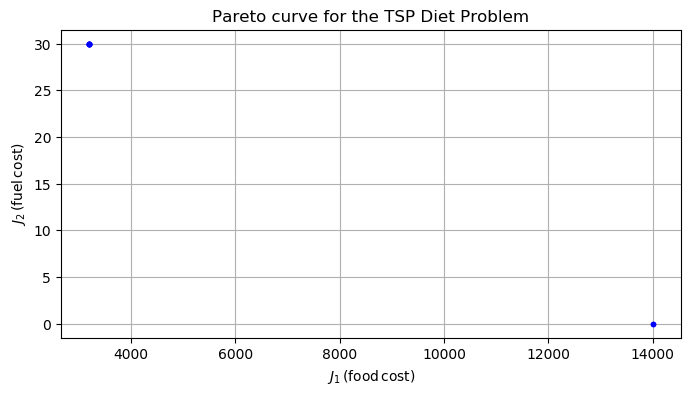

In [72]:
using PyPlot
figure(figsize=(8,4))
plot( J1, J2, "b." )
xlabel(L"J_1\, (\sf food\, cost)")
ylabel(L"J_2\, (\sf fuel\, cost)");
title("Pareto curve for the TSP Diet Problem")
grid()